### ReAct Agent using LangGraph

A ReAct agent in LangGraph combines Reasoning and Acting in a single loop.

* Reasoning: The agent uses an LLM to think through a problem step-by-step.
* Acting: Based on its reasoning, it decides whether to call a tool (e.g., API, database query) or respond directly.

* LangGraph provides a framework to define this loop, manage state, and integrate tools easily.
* This approach allows the agent to plan, execute actions, and refine answers dynamically, making it more interactive and context-aware than a simple chatbot.

In [12]:
# importing libraries

import os
from dotenv import load_dotenv
load_dotenv()

from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_tavily import TavilySearch

from langchain.chat_models import init_chat_model

from typing_extensions import TypedDict
from typing import Annotated, List

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langgraph.prebuilt import ToolNode, tools_condition

from pprint import pprint

In [5]:
# defining custom functions to use as tools.

def add_fun(a, b):
    '''this function is used to add or sum or perform a plus operation on two numbers and provide results

    Args
    a: int
    b: int

    return type: int'''

    return a + b


def subtract_fun(a, b):
    '''this function is used to subtract or perform a minus operation on two numbers and provide results

    Args
    a: int
    b: int

    return type: int'''

    return a - b




In [4]:
#using tools provided by langchain

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=500))

arxiv = ArxivQueryRun(api_wrapper= ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=500))

tavily= TavilySearch(max_results=3)

In [7]:
tools = [add_fun, subtract_fun, wikipedia, arxiv, tavily]
tools

[<function __main__.add_fun(a, b)>,
 <function __main__.subtract_fun(a, b)>,
 WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\RAGs In Depth\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=500)),
 ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=500)),
 TavilySearch(max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))]

In [10]:
#tools binded chat model

tools_model = init_chat_model(model="groq:llama-3.1-8b-instant").bind_tools(tools)
tools_model


RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x00000249633D9310>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000249633CF910>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add_fun', 'description': 'this function is used to add or sum or perform a plus operation on two numbers and provide results Args\na: int\nb: int return type: int', 'parameters': {'properties': {'a': {}, 'b': {}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'subtract_fun', 'description': 'this function is used to subtract or perform a minus

In [13]:
#defining state schema for graph

class State(TypedDict):
    messages: Annotated[List, add_messages]


In [14]:
#node definition

def model_node(state:State):
    return {"messages": tools_model.invoke(state['messages'])}


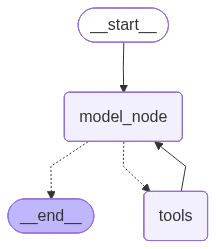

In [15]:
#graph workflow

graph = StateGraph(State)

graph.add_node("model_node", model_node)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "model_node")
graph.add_conditional_edges("model_node", tools_condition)
graph.add_edge("tools", "model_node")
graph.add_edge("model_node", END)

graph_builder = graph.compile()
graph_builder

In [16]:
query="say few lines about transformers model and then give result of adding 2 and 5"

response = graph_builder.invoke({"messages": query})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

say few lines about transformers model and then give result of adding 2 and 5
================================== Ai Message ==================================

Transformers are a type of deep learning model that are particularly well-suited for natural language processing (NLP) tasks. They were first proposed in the paper "Attention is All You Need" by Vaswani et al. in 2017 and have since become a dominant approach in many NLP applications, including language translation, text summarization, and question answering.
Tool Calls:
  add_fun (mkmkm8cf0)
 Call ID: mkmkm8cf0
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: add_fun

7
================================== Ai Message ==================================

Transformers are a type of neural network architecture that has gained significant attention in recent years due to their ability to han

In [17]:
query="firstly add 2 and 3 then subtract result from 1 to give final result"

response = graph_builder.invoke({"messages": query})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

firstly add 2 and 3 then subtract result from 1 to give final result
================================== Ai Message ==================================
Tool Calls:
  add_fun (s1xv7cwvz)
 Call ID: s1xv7cwvz
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: add_fun

5
================================== Ai Message ==================================
Tool Calls:
  subtract_fun (n09km2t7y)
 Call ID: n09km2t7y
  Args:
    a: 5
    b: 1
================================= Tool Message =================================
Name: subtract_fun

4
================================== Ai Message ==================================

The final result is 4.
